In [2]:
import re
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
import keras
import nltk
import gensim
import spacy
from nltk.corpus import wordnet
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
twitter = pd.read_csv('Mental-Health-Twitter.csv')

In [4]:
twitter.shape

(20000, 11)

In [5]:
twitter.reset_index(drop=True,inplace=True)
twitter_df = twitter[['post_text']]

In [6]:
twitter_df.head()

,post_text
0,It's just over 2 years since I was diagnosed w...
1,"It's Sunday, I need a break, so I'm planning t..."
2,Awake but tired. I need to sleep but my brain ...
3,RT @SewHQ: #Retro bears make perfect gifts and...
4,It’s hard to say whether packing lists are mak...


In [79]:
twitter_df.isnull().sum() #No NULL values

post_text    0
label        0
dtype: int64

Data Preprocessing 

In [8]:
#Removing URLs 

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

for i in range(len(twitter_df)):
  twitter_df.at[i,'post_text'] = remove_urls(twitter_df.iloc[i]['post_text'])
twitter_df.head()

,post_text
0,It's just over 2 years since I was diagnosed w...
1,"It's Sunday, I need a break, so I'm planning t..."
2,Awake but tired. I need to sleep but my brain ...
3,RT @SewHQ: #Retro bears make perfect gifts and...
4,It’s hard to say whether packing lists are mak...


In [9]:
# Creating a list using the twitter dataset
twitterData = twitter_df['post_text'].values.tolist()

# Removing all emails
data = [re.sub('\S*@\S*\s?', '', s) for s in twitterData]

# Removing the new line characters
data = [re.sub('\s+', ' ', s) for s in twitterData]

# Also removing the unnecessary single quotes
data = [re.sub("\'", "", s) for s in twitterData]

print(data[:1])

['Its just over 2 years since I was diagnosed with #anxiety and #depression. Today Im taking a moment to reflect on how far Ive come since.']


In [10]:
def newWords(sentence):
    for sentence in sentence:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # removing the punctuations

new_words = list(newWords(twitterData))

print(new_words[:1])

[['it', 'just', 'over', 'years', 'since', 'was', 'diagnosed', 'with', 'anxiety', 'and', 'depression', 'today', 'taking', 'moment', 'to', 'reflect', 'on', 'how', 'far', 've', 'come', 'since']]


In [11]:
# ngram models - bigram and trigram
bigram = gensim.models.Phrases(new_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[new_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# display a trigram
print(trigram_mod[bigram_mod[new_words[0]]])

['it', 'just', 'over', 'years', 'since', 'was', 'diagnosed', 'with', 'anxiety', 'and', 'depression', 'today', 'taking', 'moment', 'to', 'reflect', 'on', 'how', 'far', 've', 'come', 'since']


In [12]:
# stopwords, bigrams, trigrams and lemmatization functions
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words("english"))


def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for s in texts:
        doc = nlp(" ".join(s)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# Stop words are removed
noStopWords = removeStopwords(new_words)

# Bigrams
new_words_bigrams = bigrams(noStopWords)

# spacy 'en' model with tagger component 

nlp = spacy.load("en_core_web_sm")

# lemmatization
lemmatized_data = lemmatization(new_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemmatized_data[:1])

[['year', 'diagnose', 'anxiety', 'depression', 'today', 'take', 'moment', 'reflect', 'far', 'come', 'since']]


In [14]:
twitter_df = []
for i in range(len(lemmatized_data)):
    twitter_df.append(" ".join(lemmatized_data[i]))
twitter_df = pd.Series(twitter_df)

DATA VECTORIZATION

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
numFeatures = 15000
tf_vectorizer = CountVectorizer(max_df=0.95,max_features=numFeatures)
tf = tf_vectorizer.fit_transform(twitter_df)
tf_feature_names = tf_vectorizer.get_feature_names()

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
numTopics = 2
lda = LatentDirichletAllocation(n_components=numTopics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [17]:
# Document:Topic Matrix is created
lda_output = lda.transform(tf)
# naming columns
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# naming index
docnames = ['Doc' + str(i) for i in range(len(twitter_df))]
# pandas df
df_main_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get main topic for each document
main_topic = np.argmax(df_main_topic.values, axis=1)
df_main_topic['main_topic'] = main_topic

df_main_topics = df_main_topic
twitter_df1 = pd.read_csv('Mental-Health-Twitter.csv')
df_main_topics.reset_index(inplace=True,drop=True)
twitter_df1['label'] = df_main_topics['main_topic']

In [18]:
twitter_df = twitter_df1[['post_text','label']]
twitter_df.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,0
4,It’s hard to say whether packing lists are mak...,1


In [20]:
twitter_df[twitter_df1['label']==1]

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
4,It’s hard to say whether packing lists are mak...,1
5,Making packing lists is my new hobby... #movin...,1
...,...,...
19992,"After winning the pennant one year, Casey Sten...",1
19994,You will have good luck and overcome many hard...,1
19995,A day without sunshine is like night.,1
19998,"Ships are safe in harbor, but they were never ...",1


In [21]:
for i in range(5):
    print(twitter_df[twitter_df['label']==1].iloc[i][0])
    print('\n')

It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.


It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...


Awake but tired. I need to sleep but my brain has other ideas...


It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety


Making packing lists is my new hobby... #movinghouse




In [22]:
for i in range(len(twitter_df)):
  twitter_df.at[i,'post_text'] = remove_urls(twitter_df.iloc[i]['post_text'])
twitter_df.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,0
4,It’s hard to say whether packing lists are mak...,1


In [23]:
twitter_data = twitter_df['post_text'].values.tolist()
twitter_data = [re.sub('\S*@\S*\s?', '', w) for w in data]
twitter_data = [re.sub('\s+', ' ', w) for w in data]
twitter_data = [re.sub("\'", "", w) for w in data]
twitter_data = [re.sub(",", "", w) for w in data]
twitter_data = [w.lower() for w in data]

# extra dots removed
data = [w.replace('.', '') for w in data]

print(data[:1])

['Its just over 2 years since I was diagnosed with #anxiety and #depression Today Im taking a moment to reflect on how far Ive come since']


In [24]:
allTweets = np.array(data)
labels = np.array(twitter_df['label'])

In [25]:
print(len(allTweets),len(labels))

20000 20000


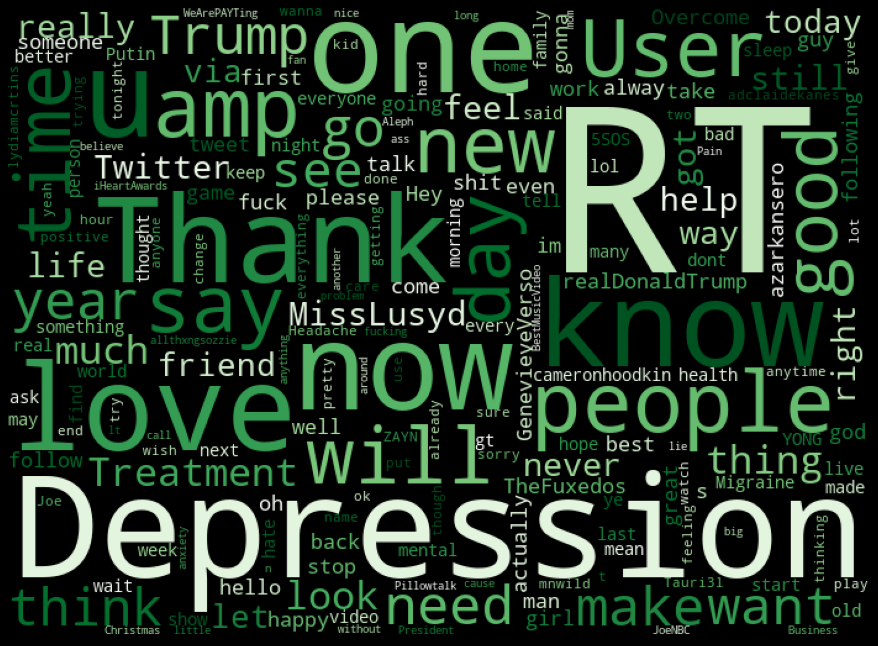

In [27]:
from wordcloud import WordCloud
t = [x for x in twitter_df['post_text']]
w = ''.join(list(map(str,t)))
tweets_wc = WordCloud(width=700,height=512,collocations=False,colormap="Greens").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(tweets_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

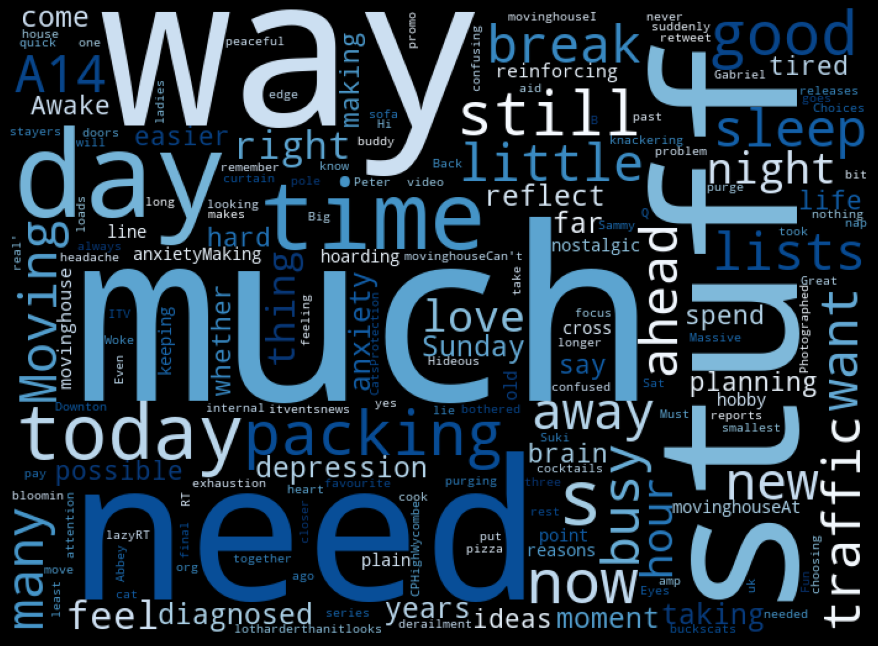

In [28]:
t=[]
a=[]
from wordcloud import WordCloud
for i in range(30):
  t=twitter_df[twitter_df['label']==1].iloc[i][0]
  a.insert(i,t)
w = ''.join(list(map(str,a)))
wc = WordCloud(width=700,height=512,collocations=False,colormap="Blues").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

BUILDING AND TRAINING THE MODEL



In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
maxWords = 20000
maxLength = 500

tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(allTweets)
sequences = tokenizer.texts_to_sequences(allTweets)
allTweets = pad_sequences(sequences, maxlen=maxLength)
print(allTweets)

[[   0    0    0 ...  113  187  278]
 [   0    0    0 ...   16    1 7761]
 [   0    0    0 ...   73  176 1224]
 ...
 [   0    0    0 ...    1  125  644]
 [   0    0    0 ...    3  398  116]
 [   0    0    0 ...    8   61 3304]]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(allTweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

15000 5000 15000 5000


Model 1 - Basic RNN with single LSTM layer

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(maxWords, 50))
model1.add(layers.LSTM(50,dropout=0.5))
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=8,validation_data=(X_test, y_test))

Epoch 1/8
469/469 [==============================] - 133s 279ms/step - loss: 0.5775 - accuracy: 0.6865 - val_loss: 0.4916 - val_accuracy: 0.7600
Epoch 2/8
469/469 [==============================] - 133s 283ms/step - loss: 0.4047 - accuracy: 0.8164 - val_loss: 0.4344 - val_accuracy: 0.7992
Epoch 3/8
469/469 [==============================] - 130s 276ms/step - loss: 0.3345 - accuracy: 0.8516 - val_loss: 0.4217 - val_accuracy: 0.8164
Epoch 4/8
469/469 [==============================] - 133s 283ms/step - loss: 0.2878 - accuracy: 0.8789 - val_loss: 0.4072 - val_accuracy: 0.8264
Epoch 5/8
469/469 [==============================] - 129s 275ms/step - loss: 0.2572 - accuracy: 0.8950 - val_loss: 0.3944 - val_accuracy: 0.8320
Epoch 6/8
469/469 [==============================] - 132s 282ms/step - loss: 0.2349 - accuracy: 0.9052 - val_loss: 0.4127 - val_accuracy: 0.8316
Epoch 7/8
469/469 [==============================] - 129s 276ms/step - loss: 0.2217 - accuracy: 0.9094 - val_loss: 0.3978 - val_ac

In [ ]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy is = ',test_acc)

157/157 - 8s - loss: 0.4204 - accuracy: 0.8374 - 8s/epoch - 49ms/step
Model accuracy is =  0.8374000191688538


In [ ]:
y_pred = model1.predict(X_test)

157/157 [==============================] - 13s 79ms/step


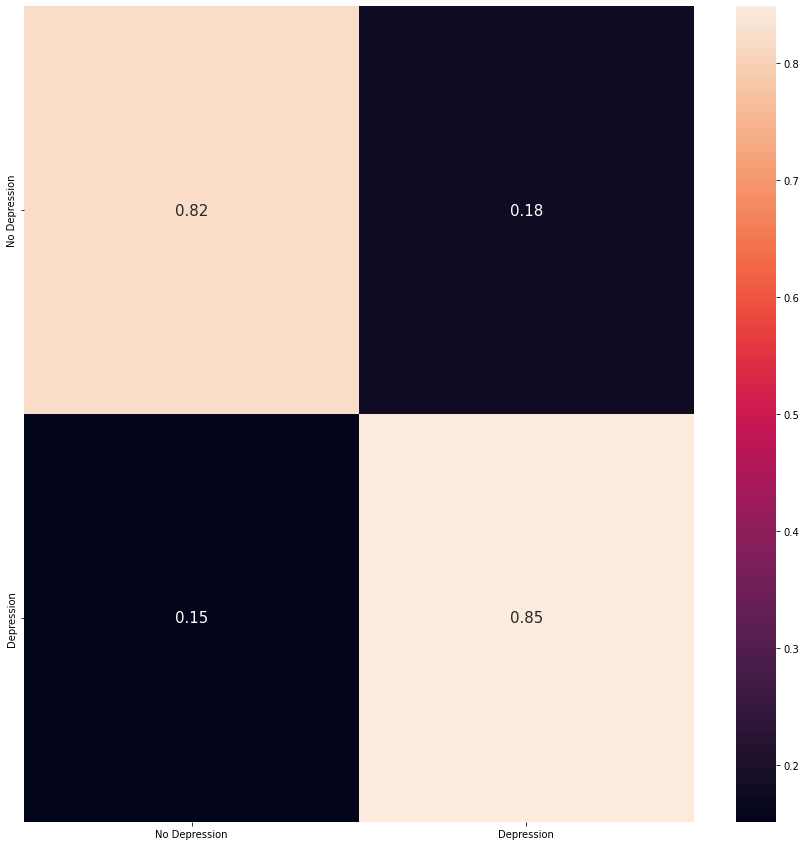

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
test = np.array(['I feel anxious lol'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model1.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")


1/1 [==============================] - 0s 41ms/step
The model predicted depressive/anxious language


Model 2 - Stacking LSTM layers and increasing the embedding dimension

In [45]:
model2 = Sequential()
model2.add(layers.Embedding(maxWords, 40))
model2.add(layers.LSTM(40,dropout=0.5,return_sequences=True))
model2.add(layers.LSTM(40,dropout=0.5))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=11,validation_data=(X_test, y_test))

Epoch 1/11
469/469 [==============================] - 179s 373ms/step - loss: 0.5940 - accuracy: 0.6711 - val_loss: 0.5229 - val_accuracy: 0.7378
Epoch 2/11
469/469 [==============================] - 170s 364ms/step - loss: 0.4248 - accuracy: 0.8049 - val_loss: 0.4501 - val_accuracy: 0.7974
Epoch 3/11
469/469 [==============================] - 168s 359ms/step - loss: 0.3408 - accuracy: 0.8493 - val_loss: 0.4244 - val_accuracy: 0.8142
Epoch 4/11
469/469 [==============================] - 164s 349ms/step - loss: 0.3002 - accuracy: 0.8729 - val_loss: 0.4218 - val_accuracy: 0.8242
Epoch 5/11
469/469 [==============================] - 164s 350ms/step - loss: 0.2626 - accuracy: 0.8923 - val_loss: 0.4042 - val_accuracy: 0.8272
Epoch 6/11
469/469 [==============================] - 165s 353ms/step - loss: 0.2422 - accuracy: 0.9022 - val_loss: 0.4256 - val_accuracy: 0.8270
Epoch 7/11
469/469 [==============================] - 166s 353ms/step - loss: 0.2242 - accuracy: 0.9101 - val_loss: 0.4093 -

In [46]:
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 8s - loss: 0.4090 - accuracy: 0.8370 - 8s/epoch - 52ms/step
Model accuracy:  0.8370000123977661


In [47]:
y_pred = model2.predict(X_test)

157/157 [==============================] - 10s 58ms/step


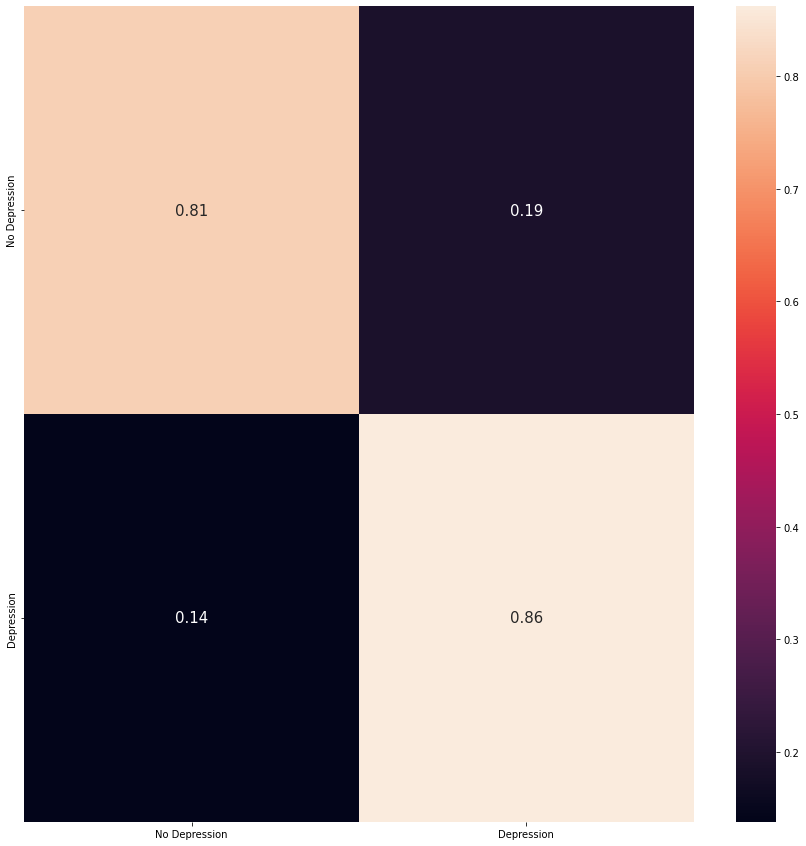

In [48]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [49]:
test = np.array(['Today is a precious gift'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model2.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 35ms/step
The model predicted other type of language


Model 3 - Bidirectional LSTM layer

In [31]:
model3 = Sequential()
model3.add(layers.Embedding(maxWords, 40))
model3.add(layers.Bidirectional(layers.LSTM(40,dropout=0.5)))
model3.add(layers.Dense(1,activation='sigmoid'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
469/469 [==============================] - 120s 248ms/step - loss: 0.5882 - accuracy: 0.6763 - val_loss: 0.5079 - val_accuracy: 0.7502
Epoch 2/10
469/469 [==============================] - 118s 251ms/step - loss: 0.4131 - accuracy: 0.8105 - val_loss: 0.4429 - val_accuracy: 0.7964
Epoch 3/10
469/469 [==============================] - 115s 246ms/step - loss: 0.3359 - accuracy: 0.8524 - val_loss: 0.4114 - val_accuracy: 0.8166
Epoch 4/10
469/469 [==============================] - 115s 245ms/step - loss: 0.2904 - accuracy: 0.8759 - val_loss: 0.4065 - val_accuracy: 0.8208
Epoch 5/10
469/469 [==============================] - 115s 244ms/step - loss: 0.2606 - accuracy: 0.8916 - val_loss: 0.3941 - val_accuracy: 0.8286
Epoch 6/10
469/469 [==============================] - 115s 245ms/step - loss: 0.2416 - accuracy: 0.9012 - val_loss: 0.3956 - val_accuracy: 0.8312
Epoch 7/10
469/469 [==============================] - 117s 250ms/step - loss: 0.2263 - accuracy: 0.9077 - val_loss: 0.3904 -

In [32]:
test_loss, test_acc = model3.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 6s - loss: 0.3980 - accuracy: 0.8380 - 6s/epoch - 41ms/step
Model accuracy:  0.8379999995231628


In [33]:
input_array = np.random.randint(5, size=(1, 5))
output_array = model3.predict(input_array)
print(output_array)

1/1 [==============================] - 1s 604ms/step
[[0.8048619]]


In [34]:
y_pred = model3.predict(X_test)

157/157 [==============================] - 7s 44ms/step


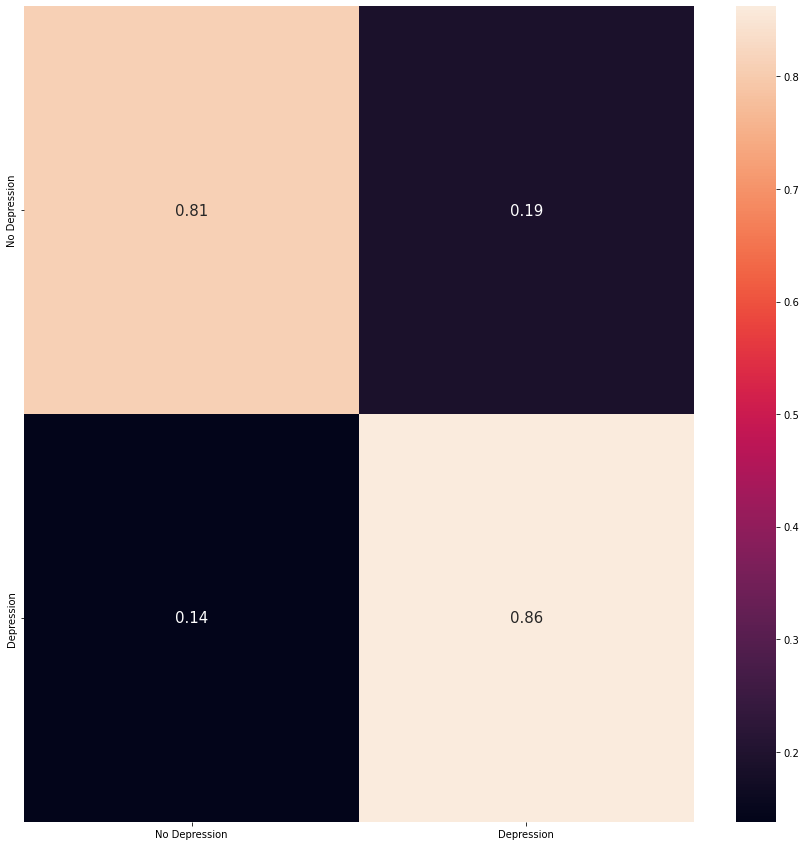

In [38]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [39]:
test = np.array(['I need a break from everything'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model3.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 39ms/step
The model predicted depressive/anxious language


MODEL 4 - LSTM with CNN

In [40]:
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
model4 = Sequential()
model4.add(layers.Embedding(maxWords, 40))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.2))

model4.add(LSTM(300))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model4.fit(X_train, y_train, epochs=7,validation_data=(X_test, y_test))

Epoch 1/7
469/469 [==============================] - 300s 633ms/step - loss: 0.5536 - accuracy: 0.7122 - val_loss: 0.4532 - val_accuracy: 0.7902
Epoch 2/7
469/469 [==============================] - 301s 643ms/step - loss: 0.3655 - accuracy: 0.8470 - val_loss: 0.3980 - val_accuracy: 0.8226
Epoch 3/7
469/469 [==============================] - 317s 677ms/step - loss: 0.2701 - accuracy: 0.8911 - val_loss: 0.4344 - val_accuracy: 0.8246
Epoch 4/7
469/469 [==============================] - 331s 707ms/step - loss: 0.2067 - accuracy: 0.9174 - val_loss: 0.4023 - val_accuracy: 0.8306
Epoch 5/7
469/469 [==============================] - 305s 651ms/step - loss: 0.1774 - accuracy: 0.9293 - val_loss: 0.4277 - val_accuracy: 0.8424
Epoch 6/7
469/469 [==============================] - 297s 634ms/step - loss: 0.1567 - accuracy: 0.9397 - val_loss: 0.4495 - val_accuracy: 0.8246
Epoch 7/7
469/469 [==============================] - 296s 632ms/step - loss: 0.1699 - accuracy: 0.9367 - val_loss: 0.4480 - val_ac

In [41]:
test_loss, test_acc = model4.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 25s - loss: 0.4480 - accuracy: 0.8410 - 25s/epoch - 160ms/step
Model accuracy:  0.8410000205039978


In [42]:
y_pred = model4.predict(X_test)

157/157 [==============================] - 27s 171ms/step


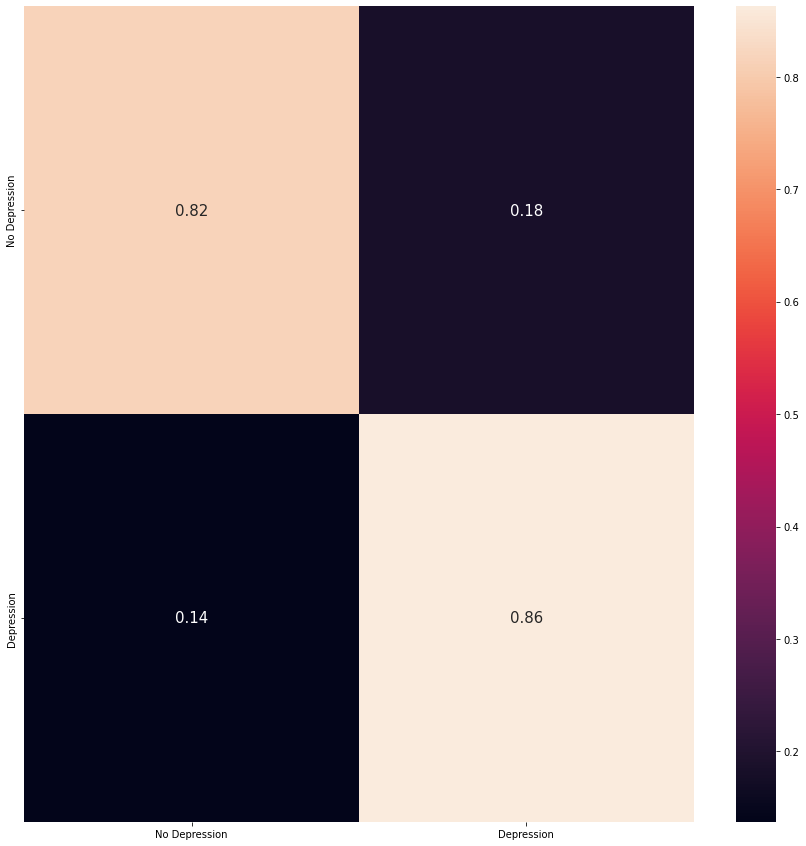

In [43]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [50]:
test = np.array(['I am excited for this week'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model4.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 37ms/step
The model predicted other type of language


TESTING: A few other random text predictions 

In [51]:
test = np.array(['I am on top of the world!'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model4.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 54ms/step
The model predicted other type of language


In [52]:
test = np.array(['I have a bad feeling in my stomach'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model3.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 85ms/step
The model predicted depressive/anxious language


In [74]:
test = np.array(['#Smiling heals'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model2.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 49ms/step
The model predicted other type of language


In [76]:
test = np.array(['Grinning from ear to ear'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model3.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 52ms/step
The model predicted other type of language


In [77]:
test = np.array(['Taking some time off to heal the soul'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model4.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 48ms/step
The model predicted depressive/anxious language
